# Los Angeles Weedmaps analysis

By [Ben Welsh](https://palewi.re/who-is-ben-welsh/)

This analysis was conducted for the May 29, 2019, Los Angeles Times story [" Black market cannabis shops thrive in L.A. even as city cracks down"](https://www.latimes.com/local/lanow/la-me-weed-pot-dispensaries-illegal-marijuana-weedmaps-black-market-los-angeles-20190529-story.html). It found more than 220 dispensaries inside Los Angeles advertised on Weedmaps.com that are not on the city's list of authorized retailers.

Due to the volatilty of the marijuana business and the high frequency of law enforcement actions against illegal operators, the number of listings can vary from day to day. So if you rerun this notebook you are likely to get slightly different results.

### How we did it

Import Python tools

In [2]:
import math
import time
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

Scrape the WeedMaps API

In [19]:
def scrape():
    """
    Provided a page number, returns all LA-area listings from the WeedMaps API
    """
    base_url = "https://api-g.weedmaps.com/discovery/v1/listings"
    
    # Configure our request payload
    params = {
        # The type of business we want to be returned
        'filter[any_retailer_services][]': ['doctor', 'storefront', 'delivery'],
        # A bounding box around the city of Los Angeles, with some area to spare
        'filter[bounding_box]': ['33.0,-119.0,36.0,-117.0'],
        # The number items we want in the return the page. I believe this is the maximum allowed.
        'page_size': ["150"],
        'size': ['100'],
        # The page number we are requesting
        'page': [1]
    }

    # Make an initial probe to determine how many pages we need to scrape
    r = requests.get(base_url, params=params)
    total_listings = r.json()['meta']['total_listings']
    
    # Do the math
    print(f"{total_listings} listings found")
    pages = int(math.ceil(total_listings / 100))
    print(f"Downloading {pages} pages")
    

    # Loop through and download each page
    dict_list = []    
    for page in range(1, pages+1):
        print(f"Downloading page {page}")
        
        # Reconfigure the payload
        params['page'] = [str(page)]

        # Make the request
        r = requests.get(base_url, params=params)

        # Parse each item
        for d in r.json()['data']['listings']:
            dict_list.append(dict(
                name=d['name'],
                slug=d['slug'],
                type=d['type'],
                address=d['address'],
                city=d['city'],
                state=d['state'],
                zipcode=d['zip_code'],
                x=d['longitude'],
                y=d['latitude'],
                url=d['web_url']
            ))
            
        # Give the API a break
        time.sleep(1)
    
    # Return the result
    return dict_list

In [ ]:
dict_list = scrape()

Convert the results into a DataFrame

In [23]:
df = pd.DataFrame(dict_list)

Read in the Los Angeles city boundaries

In [28]:
la_city = gpd.read_file("raw/los-angeles-census-place-2012.geojson") 

Convert our DataFrame to a GeoDataFrame with a matching CRS.

In [30]:
geometry = [Point(xy) for xy in zip(df.x, df.y)]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(df, crs=la_city.crs, geometry=geometry)

Pull out the LA city geometry.

In [33]:
city_limits = la_city.iloc[0].geometry

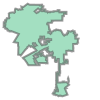

In [34]:
city_limits

Filter the scrape to the city limits.

In [50]:
gdf_la = gdf[gdf.geometry.within(city_limits)]

Clean up the file a little.

In [57]:
gdf_trimmed = gdf_la[[
    'name',
    'slug',
    'type',
    'address',
    'city',
    'zipcode',
    'url',
    'x',
    'y',
    'geometry'
]].sort_values("name")

Write the result to a file we can vet.

In [62]:
gdf_trimmed.to_csv(
    "./data/scraped-la-listings.csv",
    index=False,
    encoding="utf-8"
)

Offline this scraped file was compared to the [official list of retailers authorized by the city](https://cannabis.lacity.org/resources/authorized-retail-businesses). Licensed storefronts were marked manually. That refined list will be read back in for analysis.

In [6]:
analysis_df = pd.read_csv("./data/vetted-la-dispensaries.csv")

How many total dispensaries were listed?

In [9]:
len(analysis_df)

365

How many are registered versus unregistered?

In [10]:
analysis_df.registered.fillna(False, inplace=True)

In [11]:
analysis_df.registered.value_counts()

False    221
True     144
Name: registered, dtype: int64

What's the percentage of each?

In [13]:
analysis_df.registered.value_counts() / len(analysis_df)

False    0.605479
True     0.394521
Name: registered, dtype: float64

How many are on Florence Avenue?

In [15]:
florence = analysis_df[
    (analysis_df.address.str.upper().str.contains("FLORENCE")) &
    (analysis_df.registered == False)
]

In [16]:
len(florence)

12

What are the totals in our different regions of LA city?

In [17]:
geometry = [Point(xy) for xy in zip(analysis_df.x, analysis_df.y)]
analysis_gdf = gpd.GeoDataFrame(analysis_df, crs={'init': 'epsg:4326'}, geometry=geometry)

In [22]:
def spatial_pivot(gdf, shapes):
    sjoin = gpd.sjoin(shapes, gdf, op="intersects")
    spivot = sjoin.groupby(["name_left", "registered"]).size().rename("dispensaries").reset_index().pivot(
        index="name_left",
        columns="registered",
        values="dispensaries"
    )
    spivot['total'] = spivot.sum(axis=1)
    spivot['percent_unlicensed'] = spivot[False] / spivot['total']
    return spivot.sort_values("percent_unlicensed", ascending=False)

In [19]:
regions = gpd.read_file("http://boundaries.latimes.com/1.0/boundary-set/la-county-municipal-regions-v6/?format=geojson")

In [28]:
spatial_pivot(analysis_gdf, regions)

registered,False,True,total,percent_unlicensed
name_left,,,,
South,70,8,78,0.897436
Harbor,22,8,30,0.733333
The Eastside,16,7,23,0.695652
Central,51,30,81,0.629630
The Valley,50,69,119,0.420168
The Westside,11,19,30,0.366667
Northeast,1,3,4,0.250000


What are the totals in different neighborhoods of LA city?

In [24]:
hoods = gpd.read_file("http://boundaries.latimes.com/1.0/boundary-set/la-county-neighborhoods-v6/?format=geojson")

In [26]:
spatial_pivot(analysis_gdf, hoods).sort_values(False, ascending=False).head()

registered,False,True,total,percent_unlicensed
name_left,,,,
Downtown,21.0,7.0,28.0,0.750000
Florence,14.0,1.0,15.0,0.933333
North Hollywood,13.0,6.0,19.0,0.684211
Wilmington,10.0,1.0,11.0,0.909091
Boyle Heights,10.0,4.0,14.0,0.714286


Write out file for mapping.

In [29]:
analysis_gdf.to_file("./data/map.geojson", driver="GeoJSON")